<a href="https://colab.research.google.com/github/luizaaca/IA-ML/blob/main/Confusion_Matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-gpu==2.11.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 33.4 MB/s eta 0:00:00
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
  Attempting uninstall: keras
    Found existing installation: keras

In [2]:
!pip install scikit-learn

In [3]:
from tensorflow.keras import datasets, layers, models, metrics, backend as K
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import io
import itertools
import matplotlib.pyplot as plt
import tensorflow as tf

import numpy as np

import seaborn as sns

import pandas as pd

In [7]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

train_images, test_images = train_images / 255.0, test_images / 255.0

classes=[0,1,2,3,4,5,6,7,8,9]

11490434/11490434 [==============================] - 0s 0us/step


Modelo com camadas e neuronios reduzidos para induzir baixa taxa de acerto

In [35]:
model = models.Sequential()
model.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
# reduced number of neurons and commenting some layers in order to induce bad perfomance and have a AUC plot with some variation
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))


In [34]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x=train_images,
            y=train_labels,
            epochs=2,
            validation_data=(test_images, test_labels))

Epoch 1/2
1875/1875 [==============================] - 24s 12ms/step - loss: 0.4869 - accuracy: 0.8574 - val_loss: 0.2275 - val_accuracy: 0.9362
Epoch 2/2
1875/1875 [==============================] - 28s 15ms/step - loss: 0.1843 - accuracy: 0.9468 - val_loss: 0.1452 - val_accuracy: 0.9565


In [36]:
y_true=test_labels
y_pred_raw = model.predict(test_images)
y_pred = np.argmax(y_pred_raw, axis=-1)

313/313 [==============================] - 2s 5ms/step


In [20]:
classes=[0,1,2,3,4,5,6,7,8,9]

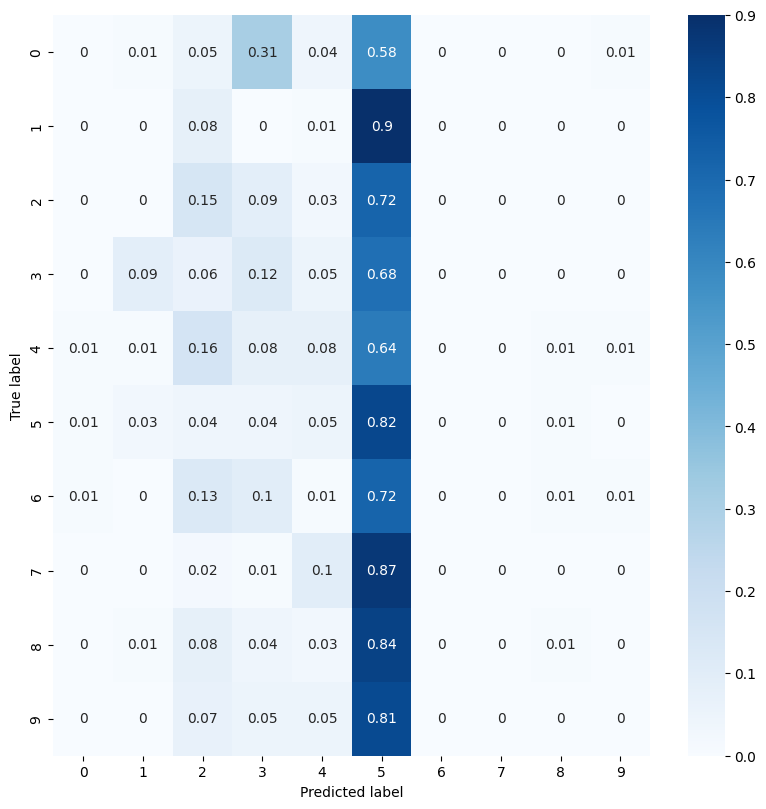

In [37]:
con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes,
                     columns = classes)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [22]:
import numpy as np

def calculate_metrics(confusion_matrix):
    """Calculates precision, recall, specificity, and F1-score for each class.

    Args:
        confusion_matrix: A NumPy array representing the confusion matrix.

    Returns:
        A dictionary containing the metrics for each class.
    """

    num_classes = confusion_matrix.shape[0]
    results = {}
    metrics = {}

    for class_index in range(num_classes):
        TP = confusion_matrix[class_index, class_index]
        FP = np.sum(confusion_matrix[:, class_index]) - TP
        FN = np.sum(confusion_matrix[class_index, :]) - TP
        TN = np.sum(confusion_matrix) - TP - FP - FN

        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        specificity = TN / (TN + FP)
        f1_score = 2 * (precision * recall) / (precision + recall)
        accuracy = (TP + TN) / np.sum(confusion_matrix)
        FPR = FP / (FP + TN)

        metrics[class_index] = {
            "precision": precision,
            "recall": recall,
            "specificity": specificity,
            "f1_score": f1_score,
            "accuracy": accuracy,
            "FPR": FPR
        }

    # Calculate overall accuracy
    overall_accuracy = np.trace(confusion_matrix) / np.sum(confusion_matrix)
    results["overall_accuracy"] = overall_accuracy
    results["metrics"] = metrics

    return results

In [38]:
# Calculate metrics using your confusion matrix
results = calculate_metrics(con_mat)

# Print the accuracy of the model
print(f"Overall accuracy: {results['overall_accuracy']:.4f}")
print("-" * 20)

# Print the metrics for each class
for class_index, class_metrics in results['metrics'].items():
    print(f"Metrics for class {class_index}:")
    print(f"  Accuracy: {class_metrics['accuracy']:.4f}")
    print(f"  Precision: {class_metrics['precision']:.4f}")
    print(f"  Sensibility/Recall: {class_metrics['recall']:.4f}")
    print(f"  Specificity: {class_metrics['specificity']:.4f}")
    print(f"  F1-score: {class_metrics['f1_score']:.4f}")
    print("-" * 20)

Overall accuracy: 0.1100
--------------------
Metrics for class 0:
  Accuracy: 0.8995
  Precision: 0.0370
  Sensibility/Recall: 0.0010
  Specificity: 0.9971
  F1-score: 0.0020
--------------------
Metrics for class 1:
  Accuracy: 0.8708
  Precision: 0.0063
  Sensibility/Recall: 0.0009
  Specificity: 0.9822
  F1-score: 0.0015
--------------------
Metrics for class 2:
  Accuracy: 0.8452
  Precision: 0.1906
  Sensibility/Recall: 0.1541
  Specificity: 0.9247
  F1-score: 0.1704
--------------------
Metrics for class 3:
  Accuracy: 0.8408
  Precision: 0.1460
  Sensibility/Recall: 0.1188
  Specificity: 0.9219
  F1-score: 0.1310
--------------------
Metrics for class 4:
  Accuracy: 0.8714
  Precision: 0.1681
  Sensibility/Recall: 0.0784
  Specificity: 0.9578
  F1-score: 0.1069
--------------------
Metrics for class 5:
  Accuracy: 0.2952
  Precision: 0.0961
  Sensibility/Recall: 0.8206
  Specificity: 0.2437
  F1-score: 0.1720
--------------------
Metrics for class 6:
  Accuracy: 0.9042
  Precis

<ipython-input-22-f1f78baf5d89>:23: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP / (TP + FP)


In [31]:
def display_auc_curve_multiclass(y_true, y_pred_probs, classes):
    """
    Exibe o gráfico da curva AUC (Area Under the Curve) para classificação multiclasse.

    Args:
        y_true: Os rótulos verdadeiros (ground truth) das amostras.
        y_pred_probs: As probabilidades previstas pelo modelo para cada classe.
        classes: Uma lista com os nomes das classes.
    """

    # Certifique-se de que os rótulos sejam binários (one-hot encoded)
    y_true_bin = label_binarize(y_true, classes=np.arange(len(classes)))

    # Calcula a curva ROC e a AUC para cada classe
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i, class_name in enumerate(classes):
        fpr[class_name], tpr[class_name], thresholds = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
        roc_auc[class_name] = auc(fpr[class_name], tpr[class_name])

    # Plota as curvas ROC para cada classe
    plt.figure(figsize=(8, 6))
    for class_name in classes:
        plt.plot(fpr[class_name], tpr[class_name], lw=2, label=f'ROC curve (area = {roc_auc[class_name]:.2f}) for {class_name}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

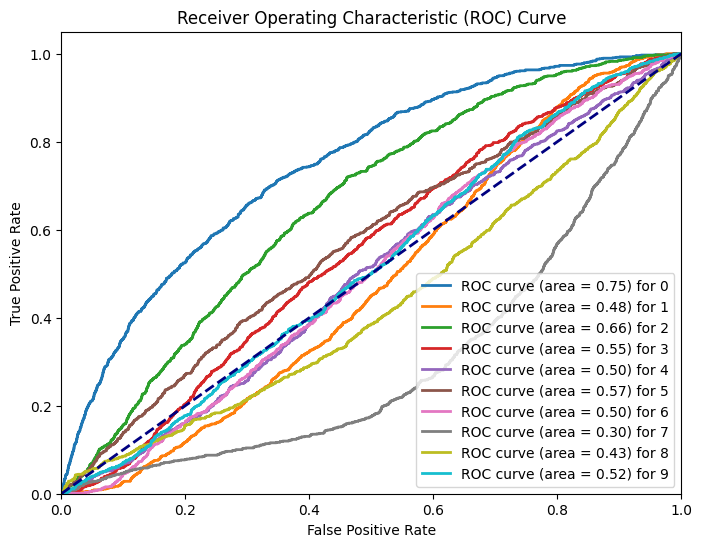

In [39]:
display_auc_curve_multiclass(y_true, y_pred_raw, classes)

Modelo com mais camadas e boa taxa de acertos

In [42]:
model1 = models.Sequential()
model1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))

model1.add(layers.Flatten())
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dense(10, activation='softmax'))

In [43]:
model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model1.fit(x=train_images,
            y=train_labels,
            epochs=3,
            validation_data=(test_images, test_labels))

Epoch 1/3
1875/1875 [==============================] - 77s 40ms/step - loss: 0.1495 - accuracy: 0.9543 - val_loss: 0.0383 - val_accuracy: 0.9875
Epoch 2/3
1875/1875 [==============================] - 74s 40ms/step - loss: 0.0466 - accuracy: 0.9855 - val_loss: 0.0373 - val_accuracy: 0.9879
Epoch 3/3
1875/1875 [==============================] - 74s 40ms/step - loss: 0.0334 - accuracy: 0.9893 - val_loss: 0.0436 - val_accuracy: 0.9873


In [44]:
y_pred_raw = model1.predict(test_images)
y_pred = np.argmax(y_pred_raw, axis=-1)

313/313 [==============================] - 3s 10ms/step


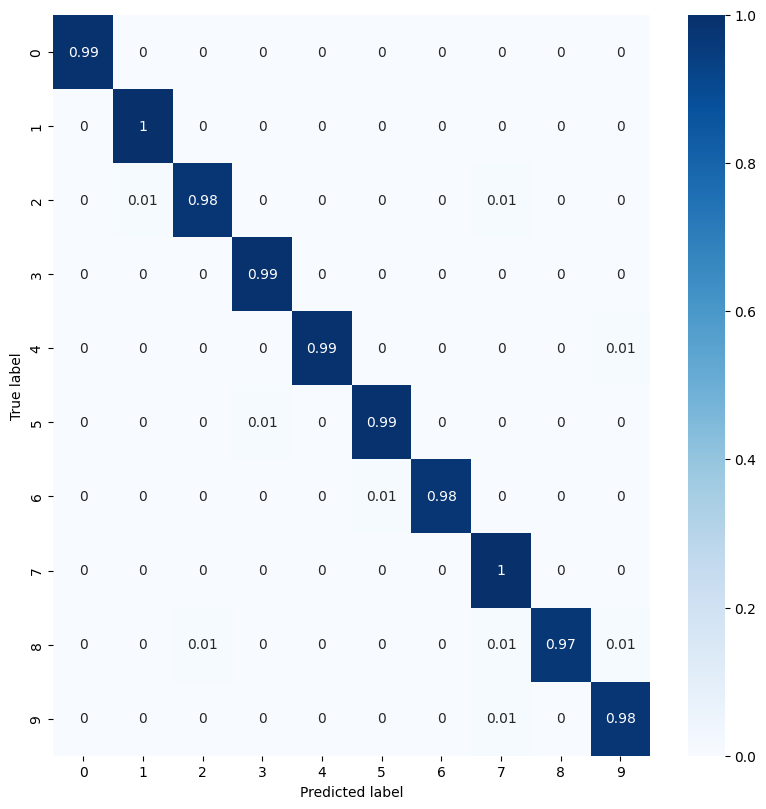

In [45]:
con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes,
                     columns = classes)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [46]:
# Calculate metrics using your confusion matrix
results = calculate_metrics(con_mat)

# Print the accuracy of the model
print(f"Overall accuracy: {results['overall_accuracy']:.4f}")
print("-" * 20)

# Print the metrics for each class
for class_index, class_metrics in results['metrics'].items():
    print(f"Metrics for class {class_index}:")
    print(f"  Accuracy: {class_metrics['accuracy']:.4f}")
    print(f"  Precision: {class_metrics['precision']:.4f}")
    print(f"  Sensibility/Recall: {class_metrics['recall']:.4f}")
    print(f"  Specificity: {class_metrics['specificity']:.4f}")
    print(f"  F1-score: {class_metrics['f1_score']:.4f}")
    print("-" * 20)

Overall accuracy: 0.9873
--------------------
Metrics for class 0:
  Accuracy: 0.9990
  Precision: 0.9949
  Sensibility/Recall: 0.9949
  Specificity: 0.9994
  F1-score: 0.9949
--------------------
Metrics for class 1:
  Accuracy: 0.9978
  Precision: 0.9835
  Sensibility/Recall: 0.9974
  Specificity: 0.9979
  F1-score: 0.9904
--------------------
Metrics for class 2:
  Accuracy: 0.9971
  Precision: 0.9883
  Sensibility/Recall: 0.9835
  Specificity: 0.9987
  F1-score: 0.9859
--------------------
Metrics for class 3:
  Accuracy: 0.9982
  Precision: 0.9892
  Sensibility/Recall: 0.9931
  Specificity: 0.9988
  F1-score: 0.9911
--------------------
Metrics for class 4:
  Accuracy: 0.9982
  Precision: 0.9908
  Sensibility/Recall: 0.9908
  Specificity: 0.9990
  F1-score: 0.9908
--------------------
Metrics for class 5:
  Accuracy: 0.9972
  Precision: 0.9779
  Sensibility/Recall: 0.9910
  Specificity: 0.9978
  F1-score: 0.9844
--------------------
Metrics for class 6:
  Accuracy: 0.9978
  Precis

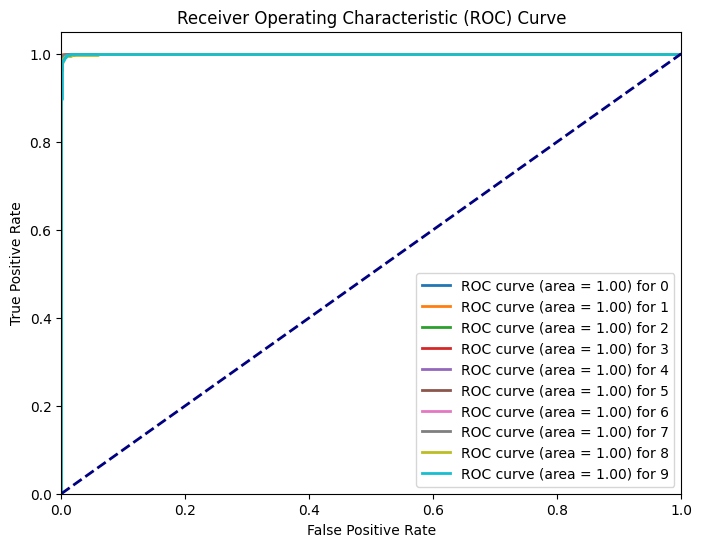

In [47]:
display_auc_curve_multiclass(y_true, y_pred_raw, classes)